In [11]:
import os
import json
import re

import numpy as np
import pandas as pd
import torch
import scanpy as sc

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [87]:
from violet.utils.dataloaders import listfiles
from violet.utils.st import predict_he_tiles, predict_visium, predict_svs
from violet.utils.preprocessing import normalize_counts, get_svs_tile_shape, get_svs_array
from violet.utils.analysis import display_predictions

In [5]:
img_dir = '/home/estorrs/violet/data/st/human_he_06252021/train/HT206B1_H8_U2/'
weights = '/home/estorrs/violet/sandbox/runs/test_run_brca_06242021/checkpoints/final.pt'
summary = '/home/estorrs/violet/sandbox/runs/test_run_brca_06242021/summary.json'

###### for visium

In [6]:
filemap = pd.read_csv('/home/estorrs/spatial-analysis/data/sample_map.txt', sep='\t')
filemap = filemap[~pd.isnull(filemap['highres_image'])]
filemap = filemap.set_index('sample_id')
filemap

,spaceranger_output,highres_image,disease
sample_id,,,
HT206B1_H8_U2,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
HT206B1_H8_U3,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
HT206B1_H8_U4,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
HT206B1_H8_U5,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
HT235B1_H1_U1,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/b...,brca
...,...,...,...
NMK_20201012,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/m...,mouse_kidney
AKICL_14w,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/m...,mouse_kidney
AKI_M_14w,/data/spatial_transcriptomics/spaceranger_outp...,/data/spatial_transcriptomics/highres_images/m...,mouse_kidney


In [7]:
spatial, tif = (filemap.loc['HT206B1_H8_U2', 'spaceranger_output'],
                filemap.loc['HT206B1_H8_U2', 'highres_image'])
adata = predict_visium(spatial, tif, weights, summary, tmp_dir='../sandbox/tmp')
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/estorrs/miniconda3/envs/violet/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3949 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'predicted_ESR1', 'predicted_PGR', 'predicted_ERBB2', 'predicted_MKI67', 'predicted_TOP2A', 'predicted_CD3G', 'predicted_CD4', 'predicted_CD8A', 'predicted_KIT', 'predicted_EPCAM', 'predicted_CDH1', 'predicted_BGN', 'predicted_FAP', 'predicted_SPARC', 'predicted_ITGAX', 'predicted_LYZ', 'predicted_CD68', 'predicted_CD14', 'predicted_SDC1', 'predicted_PECAM1', 'predicted_IL7R'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
# basic process the counts for viz purposes
adata = normalize_counts(adata)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


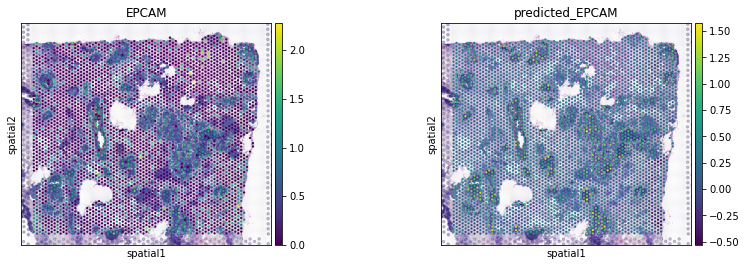

In [12]:
sc.pl.spatial(adata, color=['EPCAM', 'predicted_EPCAM'])

###### for svs

In [13]:
svs_fp = '/home/estorrs/he/cptac/sandbox/C3L-00004-21.svs'
res, background_pct = 55., .5

In [14]:
df = predict_svs(svs_fp, weights, summary, tmp_dir='../sandbox/tmp')
df

predicting 13641 tiles.


/home/estorrs/miniconda3/envs/violet/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


,ESR1,PGR,ERBB2,MKI67,TOP2A,CD3G,CD4,CD8A,KIT,EPCAM,...,BGN,FAP,SPARC,ITGAX,LYZ,CD68,CD14,SDC1,PECAM1,IL7R
C3L-00004-21_100_100,-0.145674,0.251186,-0.231278,0.177752,-0.030363,0.179881,0.668893,0.118153,-0.234896,0.137425,...,1.272607,0.008893,1.082158,0.175976,0.104541,0.811972,0.570227,0.803471,0.515432,0.473849
C3L-00004-21_100_101,-0.191287,0.265296,-0.222078,0.174070,0.043736,0.195653,0.664410,0.076010,-0.144072,0.031477,...,1.421658,0.014047,1.073698,0.228566,0.255661,0.839345,0.456988,0.802486,0.535111,0.306627
C3L-00004-21_100_102,-0.135421,0.283270,-0.296114,0.151370,-0.005814,0.140557,0.588285,0.088036,-0.082497,0.119691,...,1.433241,0.025789,1.096341,0.190227,0.202400,0.821412,0.512350,0.789412,0.532000,0.322961
C3L-00004-21_100_103,-0.125834,0.294961,-0.314068,0.224748,0.032731,0.171098,0.528181,0.057265,-0.068869,0.037486,...,1.436893,0.046298,1.131229,0.174282,0.263808,0.829280,0.500823,0.762957,0.591912,0.252112
C3L-00004-21_100_104,-0.108250,0.302449,-0.199812,0.233260,0.040472,0.065165,0.522456,0.035263,0.034477,0.099491,...,1.435919,0.046775,1.221589,0.176897,0.256590,0.761859,0.493739,0.712768,0.612591,0.134497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3L-00004-21_99_95,-0.246211,0.331464,-0.324990,0.381763,0.014320,0.323201,0.644763,0.240659,-0.342178,0.414022,...,1.259056,-0.154127,1.081141,0.259545,0.174089,0.963441,0.493506,0.852557,0.469519,0.509811
C3L-00004-21_99_96,-0.248808,0.313753,-0.291527,0.204273,-0.011232,0.260539,0.642908,0.150271,-0.130716,0.101697,...,1.474137,-0.023113,1.135898,0.358353,0.195756,0.911573,0.541124,0.811800,0.601397,0.345003
C3L-00004-21_99_97,-0.245725,0.269669,-0.173621,0.327254,-0.088751,0.313020,0.669445,0.412093,-0.348213,0.344141,...,1.249504,-0.065897,1.187245,0.264220,0.260001,0.949345,0.494073,0.837220,0.456854,0.565299
C3L-00004-21_99_98,-0.267744,0.294651,-0.281979,0.367411,-0.047325,0.357875,0.711239,0.242295,-0.341859,0.334697,...,1.343538,-0.134707,1.053960,0.216641,0.176665,0.880761,0.460459,0.856754,0.349050,0.471684


In [86]:
scale = .1
# res = json.load(open(summary))['dataset']['resolution']
res = 55.
img = get_svs_array(svs_fp, scale=scale)

(n_rows, n_cols), tile_size = get_svs_tile_shape(svs_fp, resolution=res)
row_offset = img.shape[0] % n_rows
col_offset = img.shape[1] % n_cols

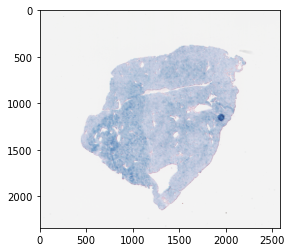

In [91]:
display_predictions(img, df, tile_size, 'EPCAM', scale,
                   row_offset=row_offset, col_offset=col_offset,
                   alpha=.3)

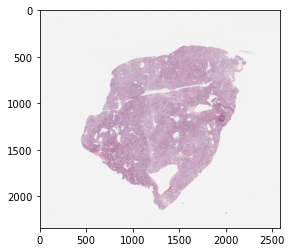

In [92]:
plt.imshow(img)